# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В распоряжении имею исторические данные: технические характеристики, комплектации и цены автомобилей. Задача - построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [1]:
# Импортирую необходимые библиотеки.
! pip install lightgbm
! pip install sweetviz
import lightgbm as lgb
import numpy as np
import pandas as pd
import sweetviz as sv
import time
import warnings
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
warnings.filterwarnings("ignore")

     |████████████████████████████████| 15.1 MB 1.2 MB/s eta 0:00:01


In [3]:
# Импортирую и изучу данные
df = pd.read_csv('/datasets/autos.csv')
#df = pd.read_csv('autos.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [4]:
df.head(10)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06


In [5]:
# Сделаю расширенный EDA-анализ
report = sv.analyze([df, " EDA-анализ данных"])
report.show_html('analysis.html')

                                             |          | [  0%]   00:00 -> (? left)

Report analysis.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [6]:
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Имею 16 столбцов, 354 369 строк. Существуют пропуски некоторых данных.
- Столбец Price (цена в Евро) имеет нули. Необходимо удалить строки с нулевыми ценами.
- Столбец RegistrationYear (год регистрации авто) имеет годы более 2023 и 1000, что явно являются выбросами.
- Столбец Power (мощность в л.с.) имеет нули, а также очень большие значения - до 20000. Это нереально много.
- Столбец RegistrationMonth (месяц регистрации авто) имеет нули.
- Столбец NumberOfPictures (Количество фотографий автомобиля) - во всех строках значение 0, поэтому избавлюсь от этого столбца.

DateCrawled (дата скачивания анкеты из базы), DateCreated (дата создания анкеты), LastSeen (дата последней активности пользователя) - данные колонки в обучении моделей не пригодятся, их можно будет удалить.

In [7]:
# Проверю на наличие дубликатов
df.duplicated().sum()

4

In [8]:
# Удалю явные дубликаты
df.drop_duplicates(inplace=True)

In [9]:
# Удалю колонки, не влияющие на дальнейшее обучение
df.drop(columns = ['DateCrawled', 'DateCreated', 'NumberOfPictures', 'LastSeen', 'RegistrationMonth'], inplace=True)

In [10]:
# Удаляю строки с нулевыми ценой, мощностью. 
df = df[df['Price'] != 0]
df = df[df['Power'] != 0]

In [11]:
# Удалю данные с годом регистрации до 1900 и после 2016 (максимальный год — дата скачивания анкеты (DateCrawled))
df = df[df['RegistrationYear'] >= 1900]
df = df[df['RegistrationYear'] <= 2016]

In [12]:
# Посмотрю количество пропусков по столбцам
print("Количество пропусков по столбцам \n", df.isnull().sum().sort_values(ascending = False))

Количество пропусков по столбцам 
 Repaired            43074
FuelType            15636
Model               11237
VehicleType         11074
Gearbox              5402
Price                   0
RegistrationYear        0
Power                   0
Kilometer               0
Brand                   0
PostalCode              0
dtype: int64


Больше всего пропусков в столбце Repaired (Была машина в ремонте или нет) - 43074 шт.

Далее идут VehicleType (тип кузова), FuelType (тип топлива), Model (модель), Gearbox (тип коробки передач).

Восстановить данные не представляется возможным, поэтому заполню их константным значением "unknown".

In [13]:
# df = df.dropna()

In [14]:
# Заполню пропуски константным значением "unknown"
df['Repaired'] = df['Repaired'].fillna('unknown')
df['VehicleType'] = df['VehicleType'].fillna('unknown')
df['FuelType'] = df['FuelType'].fillna('unknown')
df['Model'] = df['Model'].fillna('unknown')
df['Gearbox'] = df['Gearbox'].fillna('unknown')

<AxesSubplot:>

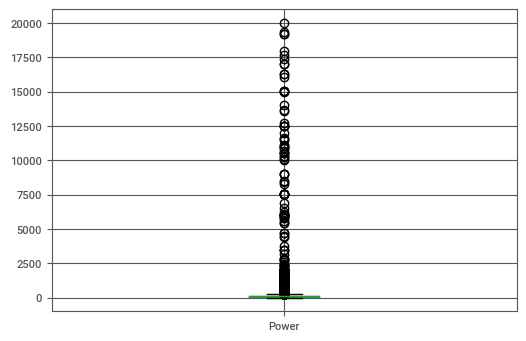

In [15]:
# Столбец Power (мощность в л.с.) имел слишком большие значения. Построю boxplot.
df.boxplot(column = 'Power')

<AxesSubplot:>

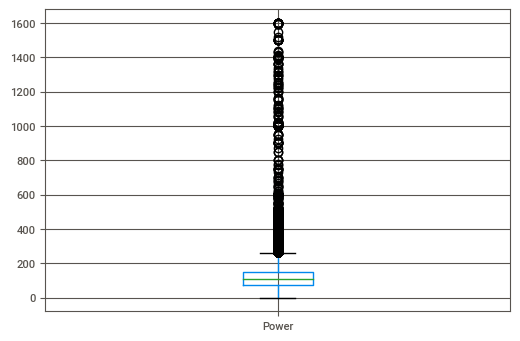

In [16]:
# В данных много выбросов. Т.к. самый мощный авто в мире имеет мощность 1600 л.с., удалю всё, что больше этой цифры.
df = df[df['Power'] <= 1600]
df.boxplot(column = 'Power')

In [17]:
df.shape

(296743, 11)

Было 16 столбцов, 354 369 строк, осталось 11 столбцов, 296 743 строк (84% от первоначального датасета).

Данные очищены, осталось закодировать категориальные признаки, выделить целевой признак, и разделить датасет на обучающую, валидационную и тестовую выборки

In [18]:
# Выделю целевой признак
features = df.drop(['Price'], axis=1)
target = df['Price']

In [19]:
# Разобъю датасет на обучающую, валидационную и тестовую выборки
features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.4, random_state=12345)
features_valid, features_test, target_valid, target_test = train_test_split(
    features_valid, target_valid, test_size=0.5, random_state=12345)

In [20]:
# Для кодирования категориальных признаков применю технику Ordinal Encoding
cat_columns = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=9999)
encoder.fit(features_train[cat_columns])

features_train_ord = features_train.copy()
features_valid_ord = features_valid.copy()
features_test_ord = features_test.copy()

features_train_ord[cat_columns] = encoder.transform(features_train_ord[cat_columns])
features_valid_ord[cat_columns] = encoder.transform(features_valid_ord[cat_columns])
features_test_ord[cat_columns] = encoder.transform(features_test_ord[cat_columns])

In [21]:
# Отмасштабирую числовые признаки методом стандартизации данных
numeric = ['RegistrationYear', 'Power', 'Kilometer', 'PostalCode']
scaler = StandardScaler()
scaler.fit(features_train_ord[numeric])

features_train = features_train_ord.copy()
features_valid = features_valid_ord.copy()
features_test = features_test_ord.copy()

features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

**Выводы**
В первом разделе проделана следующая работа:
- Загружены необходимые библиотеки.
- Загружены данные.
- Изучены данные. Сделан расширенный EDA-анализ.
- Выявлено наличие пропусков в некоторых данных. Так как восстановить данные не представлялось возможным, заменили их на значение 'unknoun'.
- Выявил и удалил явные дубликаты.
- Удалил колонки, не влияющие на дальнейшее обучение.
- Удалил строки с нулевыми ценой, мощностью и месяцем.
- Удалил данные до 1900 года и после 2016 года (максимальный год скачивания анкеты)
- Удалил выбросы по столбцу Power (по мощности свыше 1600 л.с.).
- Для кодирования категориальных признаков применил технику Ordinal Encoding.
- Выделил целевой признак.
- Разбил датасет на обучающую, валидационную и тестовую выборки.
- Отмасштабировал числовые признаки, методом стандартизации данных.

Теперь данные готовы для обучения моделей.

## Обучение моделей

**LightGBM**

In [22]:
lgb_train = lgb.Dataset(features_train, target_train)
lgb_valid = lgb.Dataset(features_valid, target_valid, reference=lgb_train)

In [23]:
# Функция обучения модели LightGBM
def mod_train(parametrs):
    lgbm = lgb.train(parametrs, lgb_train, num_boost_round=40, valid_sets=lgb_valid, early_stopping_rounds=5)
    return lgbm

In [24]:
# Функция проверки предсказания и рассчёта RMSE
def rmse(model):
    targ_pred = model.predict(features_valid)
    print('RMSE:', mean_squared_error(target_valid, targ_pred) ** 0.5)

In [25]:
%%time
# обучу модель с настройками по умолчанию
param = {'metric': 'rmse', 'force_row_wise': True}
mod_train(param)

[LightGBM] [Info] Total Bins 908
[LightGBM] [Info] Number of data points in the train set: 178045, number of used features: 10
[LightGBM] [Info] Start training from score 4847.430374
[1]	valid_0's rmse: 4292.86
Training until validation scores don't improve for 5 rounds
[2]	valid_0's rmse: 4002.75
[3]	valid_0's rmse: 3745.84
[4]	valid_0's rmse: 3522.19
[5]	valid_0's rmse: 3327.13
[6]	valid_0's rmse: 3150.68
[7]	valid_0's rmse: 2998.97
[8]	valid_0's rmse: 2864.69
[9]	valid_0's rmse: 2750.55
[10]	valid_0's rmse: 2648.94
[11]	valid_0's rmse: 2559.94
[12]	valid_0's rmse: 2480.04
[13]	valid_0's rmse: 2410.84
[14]	valid_0's rmse: 2349.64
[15]	valid_0's rmse: 2297.68
[16]	valid_0's rmse: 2248.88
[17]	valid_0's rmse: 2205.66
[18]	valid_0's rmse: 2167.64
[19]	valid_0's rmse: 2132.4
[20]	valid_0's rmse: 2098.93
[21]	valid_0's rmse: 2071.62
[22]	valid_0's rmse: 2044.36
[23]	valid_0's rmse: 2020.71
[24]	valid_0's rmse: 1998.27
[25]	valid_0's rmse: 1977.51
[26]	valid_0's rmse: 1958.88
[27]	valid_0'

RMSE при обучении 1813.12, время обучения 0.89сек.

Попробую разные гиперпараметры при обучении модели

In [26]:
%%time
# Попробую менять скорость обучения
for i in np.arange(0.38, 0.4, 0.01):
    param = {'learning_rate':i, 'metric': 'rmse', 'force_row_wise': True}
    mod_train(param)  

[LightGBM] [Info] Total Bins 908
[LightGBM] [Info] Number of data points in the train set: 178045, number of used features: 10
[LightGBM] [Info] Start training from score 4847.430374
[1]	valid_0's rmse: 3425.98
Training until validation scores don't improve for 5 rounds
[2]	valid_0's rmse: 2779.89
[3]	valid_0's rmse: 2409.87
[4]	valid_0's rmse: 2207.34
[5]	valid_0's rmse: 2081.52
[6]	valid_0's rmse: 1997.77
[7]	valid_0's rmse: 1937.97
[8]	valid_0's rmse: 1891.54
[9]	valid_0's rmse: 1863.79
[10]	valid_0's rmse: 1846.67
[11]	valid_0's rmse: 1819.91
[12]	valid_0's rmse: 1804.15
[13]	valid_0's rmse: 1794.13
[14]	valid_0's rmse: 1785.05
[15]	valid_0's rmse: 1774.61
[16]	valid_0's rmse: 1762.6
[17]	valid_0's rmse: 1753.33
[18]	valid_0's rmse: 1744.81
[19]	valid_0's rmse: 1737.96
[20]	valid_0's rmse: 1734.34
[21]	valid_0's rmse: 1729.92
[22]	valid_0's rmse: 1726.08
[23]	valid_0's rmse: 1721.59
[24]	valid_0's rmse: 1717.91
[25]	valid_0's rmse: 1713.4
[26]	valid_0's rmse: 1706.06
[27]	valid_0's

Качество модели растёт с ростом скорости, но до значения 0.39 (RMSE: 1657.29), при дальнейшем повышении скорости качество ухудшается.

In [27]:
%%time
# Попробую менять тип бустинга
types = ['gbrt', 'dart', 'goss']
for type in types:
    param = {'boosting_type': type, 'learning_rate':0.39, 'metric': 'rmse', 'force_row_wise': True}
    mod_train(param)    

[LightGBM] [Info] Total Bins 908
[LightGBM] [Info] Number of data points in the train set: 178045, number of used features: 10
[LightGBM] [Info] Start training from score 4847.430374
[1]	valid_0's rmse: 3397.61
Training until validation scores don't improve for 5 rounds
[2]	valid_0's rmse: 2749.79
[3]	valid_0's rmse: 2389.92
[4]	valid_0's rmse: 2204.05
[5]	valid_0's rmse: 2076.27
[6]	valid_0's rmse: 1989.86
[7]	valid_0's rmse: 1929.1
[8]	valid_0's rmse: 1884.63
[9]	valid_0's rmse: 1850.48
[10]	valid_0's rmse: 1824.39
[11]	valid_0's rmse: 1810.43
[12]	valid_0's rmse: 1796.76
[13]	valid_0's rmse: 1784.81
[14]	valid_0's rmse: 1770.68
[15]	valid_0's rmse: 1759.01
[16]	valid_0's rmse: 1751.24
[17]	valid_0's rmse: 1743.61
[18]	valid_0's rmse: 1733.16
[19]	valid_0's rmse: 1726.86
[20]	valid_0's rmse: 1721.89
[21]	valid_0's rmse: 1715.29
[22]	valid_0's rmse: 1709.8
[23]	valid_0's rmse: 1708.94
[24]	valid_0's rmse: 1704.63
[25]	valid_0's rmse: 1699.9
[26]	valid_0's rmse: 1694.42
[27]	valid_0's 

Самый низкий RMSE (1657.29) в режиме по-умолчанию: 'gbrt' (дерево решений с градиентным бустингом)

In [28]:
%%time
# Попробую менять глубину дерева и количество листьев
for i in range(12,15):
    param = {'max_depth':i, 'num_leaves':2**i, 'learning_rate':0.39, 'metric': 'rmse', 'force_row_wise': True, 'n_jobs':-1} 
    mod_train(param)   

[LightGBM] [Info] Total Bins 908
[LightGBM] [Info] Number of data points in the train set: 178045, number of used features: 10
[LightGBM] [Info] Start training from score 4847.430374
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's rmse: 3180.03
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's rmse: 2404.86
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's rmse: 2010.75
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	valid_0's rmse: 1817.57
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	valid_0's rmse: 1723.33
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6]	valid_0's rmse: 1675.09
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7]	valid_0's rmse: 1648.17
[LightGBM] [Warning] No further spli

RMSE улучшается до глубины 13 деревьев (количество листьев 8192), далее модель начинает работать хуже. Лучшее значение RMSE при этом: 1579.48.

In [29]:
%%time
# Теперь поиграю количеством деревьев
trees = [10, 50, 100, 500, 1000, 5000]
for i in trees:
    param = {'n_estimators':i, 'max_depth':13, 'num_leaves':8192, 'learning_rate':0.39, 'metric': 'rmse',
             'force_row_wise': True, 'n_jobs':-1}
    mod_train(param)    

[LightGBM] [Info] Total Bins 908
[LightGBM] [Info] Number of data points in the train set: 178045, number of used features: 10
[LightGBM] [Info] Start training from score 4847.430374
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's rmse: 3168.13
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's rmse: 2382.83
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's rmse: 1987.78
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	valid_0's rmse: 1796.84
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	valid_0's rmse: 1709.02
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6]	valid_0's rmse: 1664.3
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7]	valid_0's rmse: 1640.56
[LightGBM] [Warning] No further split

Для нашего набора данных производительность улучшается до 32 деревьев (RMSE:1579.48).

In [30]:
%%time
# Попробую модель с оптимальными настройками на основе проведённых исследований
param = {'n_estimators':32, 'max_depth':13, 'num_leaves':8192, 'learning_rate':0.39, 'metric': 'rmse',
         'force_row_wise': True, 'n_jobs':-1}
best_lgbm = mod_train(param)  

[LightGBM] [Info] Total Bins 908
[LightGBM] [Info] Number of data points in the train set: 178045, number of used features: 10
[LightGBM] [Info] Start training from score 4847.430374
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's rmse: 3168.13
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's rmse: 2382.83
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's rmse: 1987.78
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	valid_0's rmse: 1796.84
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	valid_0's rmse: 1709.02
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6]	valid_0's rmse: 1664.3
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7]	valid_0's rmse: 1640.56
[LightGBM] [Warning] No further split

Точность обучения RMSE: 1579.48;
Время обучения: 3.45 сек.
Это лучшая модель

In [31]:
%%time
# Проверю предсказание и RMSE
rmse(best_lgbm)

RMSE: 1579.4812677488333
CPU times: user 328 ms, sys: 57 µs, total: 328 ms
Wall time: 218 ms


Точность предсказания RMSE: 1579.48
Время предсказания: 0,34 сек

Итак, для модели "LightGBM", оптимальные настройки: 'boosting_type': 'gbrt', 'n_estimators': 32, 'max_depth': 13, 'num_leaves': 8192, 'learning_rate':0.39. RMSE тренировки и предсказания: 1579.48. Время тренировки: 3.45сек., время предсказания: 0,34сек.

**CatBoost**

In [32]:
# Функция обучения модели CatBoost
def catboost_train(parametrs):
    cbr = CatBoostRegressor(**parametrs)
    cb = cbr.fit(features_train, target_train, eval_set=(features_valid, target_valid))
    return cb

In [33]:
%%time
# обучу модель с настройками по умолчанию
param = {'loss_function':'RMSE', 'random_state': 12345}
catboost_train(param)

Learning rate set to 0.114876
0:	learn: 4258.9097082	test: 4280.5141972	best: 4280.5141972 (0)	total: 77.1ms	remaining: 1m 17s
1:	learn: 3953.9208933	test: 3973.7900517	best: 3973.7900517 (1)	total: 105ms	remaining: 52.3s
2:	learn: 3700.6032084	test: 3718.3058298	best: 3718.3058298 (2)	total: 129ms	remaining: 43s
3:	learn: 3485.3293604	test: 3501.3039165	best: 3501.3039165 (3)	total: 153ms	remaining: 38.1s
4:	learn: 3290.7360654	test: 3305.5602660	best: 3305.5602660 (4)	total: 177ms	remaining: 35.2s
5:	learn: 3123.1902339	test: 3136.1989973	best: 3136.1989973 (5)	total: 203ms	remaining: 33.6s
6:	learn: 2977.3177633	test: 2988.6647748	best: 2988.6647748 (6)	total: 227ms	remaining: 32.2s
7:	learn: 2859.2080047	test: 2868.5883195	best: 2868.5883195 (7)	total: 251ms	remaining: 31.1s
8:	learn: 2755.1427769	test: 2763.0559005	best: 2763.0559005 (8)	total: 276ms	remaining: 30.4s
9:	learn: 2664.6691416	test: 2670.4740931	best: 2670.4740931 (9)	total: 300ms	remaining: 29.7s
10:	learn: 2587.4915

Точность на обучении RMSE: 1575.10
Время обучения: 47.7 сек.

In [34]:
%%time
# Попробую менять принцип жадного алгоритма поиска.
gp = ['SymmetricTree', 'Depthwise', 'Lossguide']
for i in gp:
    param = {'grow_policy':i, 'loss_function':'RMSE', 'random_state': 12345}
    catboost_train(param)    

Learning rate set to 0.114876
0:	learn: 4258.9097082	test: 4280.5141972	best: 4280.5141972 (0)	total: 28ms	remaining: 28s
1:	learn: 3953.9208933	test: 3973.7900517	best: 3973.7900517 (1)	total: 53.7ms	remaining: 26.8s
2:	learn: 3700.6032084	test: 3718.3058298	best: 3718.3058298 (2)	total: 76.5ms	remaining: 25.4s
3:	learn: 3485.3293604	test: 3501.3039165	best: 3501.3039165 (3)	total: 100ms	remaining: 24.9s
4:	learn: 3290.7360654	test: 3305.5602660	best: 3305.5602660 (4)	total: 123ms	remaining: 24.4s
5:	learn: 3123.1902339	test: 3136.1989973	best: 3136.1989973 (5)	total: 146ms	remaining: 24.2s
6:	learn: 2977.3177633	test: 2988.6647748	best: 2988.6647748 (6)	total: 169ms	remaining: 23.9s
7:	learn: 2859.2080047	test: 2868.5883195	best: 2868.5883195 (7)	total: 194ms	remaining: 24s
8:	learn: 2755.1427769	test: 2763.0559005	best: 2763.0559005 (8)	total: 218ms	remaining: 24s
9:	learn: 2664.6691416	test: 2670.4740931	best: 2670.4740931 (9)	total: 241ms	remaining: 23.8s
10:	learn: 2587.4915838	t

Лучшие показатели - в режиме "Depthwise" (дерево строится шаг за шагом, пока не достигнет нужной глубины, листья разделяются с использованием условия, приводящего к лушему уменьшению потерь). RMSE=1532.75, 999 итераций.

In [35]:
%%time
# Попробую подобрать глубину деревьев
for i in range(11,14):
    param = {'depth':i, 'grow_policy':'Depthwise', 'loss_function':'RMSE', 'random_state': 12345}
    catboost_train(param)    

Learning rate set to 0.114876
0:	learn: 4195.9700442	test: 4222.1515087	best: 4222.1515087 (0)	total: 195ms	remaining: 3m 15s
1:	learn: 3842.4325360	test: 3869.9999078	best: 3869.9999078 (1)	total: 386ms	remaining: 3m 12s
2:	learn: 3534.9632463	test: 3563.7252393	best: 3563.7252393 (2)	total: 605ms	remaining: 3m 20s
3:	learn: 3267.7509214	test: 3297.0334820	best: 3297.0334820 (3)	total: 806ms	remaining: 3m 20s
4:	learn: 3037.3946769	test: 3068.2525234	best: 3068.2525234 (4)	total: 994ms	remaining: 3m 17s
5:	learn: 2834.6375257	test: 2867.3353324	best: 2867.3353324 (5)	total: 1.19s	remaining: 3m 16s
6:	learn: 2659.5026827	test: 2693.9224930	best: 2693.9224930 (6)	total: 1.38s	remaining: 3m 16s
7:	learn: 2508.5814932	test: 2545.5737209	best: 2545.5737209 (7)	total: 1.58s	remaining: 3m 16s
8:	learn: 2378.7599169	test: 2418.5543700	best: 2418.5543700 (8)	total: 1.77s	remaining: 3m 14s
9:	learn: 2267.7334452	test: 2309.1236685	best: 2309.1236685 (9)	total: 1.95s	remaining: 3m 13s
10:	learn:

Самый низкий RMSE=1489,83 получился у нас при глубине 12, далее RMSE начал ухудшаться. Количество итераций 619.

In [36]:
%%time
# Попробую подобрать скорость обучения
for i in np.arange(0.06, 0.08, 0.01):
    param = {'learning_rate':i, 'grow_policy':'Depthwise', 'depth':12, 'loss_function':'RMSE', 'random_state': 12345}
    catboost_train(param)    

0:	learn: 4387.6880118	test: 4413.7665089	best: 4413.7665089 (0)	total: 252ms	remaining: 4m 12s
1:	learn: 4187.9442686	test: 4214.2082242	best: 4214.2082242 (1)	total: 506ms	remaining: 4m 12s
2:	learn: 3999.8091308	test: 4026.7938124	best: 4026.7938124 (2)	total: 782ms	remaining: 4m 20s
3:	learn: 3825.1682379	test: 3852.2618033	best: 3852.2618033 (3)	total: 1.04s	remaining: 4m 18s
4:	learn: 3661.2649419	test: 3689.1815926	best: 3689.1815926 (4)	total: 1.31s	remaining: 4m 20s
5:	learn: 3510.4458395	test: 3539.6192696	best: 3539.6192696 (5)	total: 1.6s	remaining: 4m 25s
6:	learn: 3368.9865081	test: 3399.0275604	best: 3399.0275604 (6)	total: 1.85s	remaining: 4m 23s
7:	learn: 3236.6837388	test: 3267.9316486	best: 3267.9316486 (7)	total: 2.1s	remaining: 4m 20s
8:	learn: 3113.3668337	test: 3145.9030254	best: 3145.9030254 (8)	total: 2.37s	remaining: 4m 20s
9:	learn: 2998.4098223	test: 3032.3049917	best: 3032.3049917 (9)	total: 2.63s	remaining: 4m 20s
10:	learn: 2892.0894491	test: 2927.2200810

При увеличении скорости обучения - RMSE уменьшается, до скорости 0,07 (RMSE=1482,82, 933 итерации), при дальнейшем увеличении скорости - RMSE ухудшается.

In [37]:
%%time
# Попробую модель с оптимальными настройками на основе проведённых исследований
param = {'grow_policy':'Depthwise', 'depth':12, 'learning_rate':0.07, 'iterations':934, 'loss_function':'RMSE',
         'random_state': 12345}
best_catboost = catboost_train(param)

0:	learn: 4352.1763832	test: 4378.4514632	best: 4378.4514632 (0)	total: 256ms	remaining: 3m 58s
1:	learn: 4121.4793018	test: 4147.9045210	best: 4147.9045210 (1)	total: 519ms	remaining: 4m 2s
2:	learn: 3908.4853211	test: 3936.3393293	best: 3936.3393293 (2)	total: 784ms	remaining: 4m 3s
3:	learn: 3710.8427845	test: 3739.2418458	best: 3739.2418458 (3)	total: 1.04s	remaining: 4m 1s
4:	learn: 3530.2756387	test: 3560.0677030	best: 3560.0677030 (4)	total: 1.28s	remaining: 3m 58s
5:	learn: 3364.2033080	test: 3394.8397590	best: 3394.8397590 (5)	total: 1.55s	remaining: 4m
6:	learn: 3211.0919083	test: 3243.3405695	best: 3243.3405695 (6)	total: 1.85s	remaining: 4m 4s
7:	learn: 3070.4687357	test: 3103.5683146	best: 3103.5683146 (7)	total: 2.12s	remaining: 4m 5s
8:	learn: 2940.0863265	test: 2974.7618486	best: 2974.7618486 (8)	total: 2.37s	remaining: 4m 3s
9:	learn: 2818.4130268	test: 2854.5607941	best: 2854.5607941 (9)	total: 2.62s	remaining: 4m 2s
10:	learn: 2709.2066701	test: 2747.3849676	best: 27

RMSE сохранилась (1482,82), скорость обучения 13 мин. 31 сек. Это лучшая модель.

Оптимальные параметры: 'grow_policy': 'Depthwise', 'depth': 12, 'learning_rate': 0.07, 'iterations': 934.

In [38]:
%%time
# Проверю предсказание и RMSE
rmse(best_catboost)

RMSE: 1482.821550996023
CPU times: user 2.45 s, sys: 4.18 ms, total: 2.45 s
Wall time: 2.45 s


Точность предсказания RMSE: 1482.82
Время предсказания: 3.11 сек.

**SGDRegressor**

In [39]:
# Создаю модель
sgd = SGDRegressor(random_state=12345)

In [40]:
# создаю кросс-валидатор для последующего обучения моделей
cv = KFold(n_splits=3, shuffle=True, random_state=12345)

In [41]:
# Создаю словарь, в котором определяю параметры модели, которые передам через GridSearchCV в модель,
# чтобы получить наилучшие параметры.
parameters = {'loss' : ['squared_loss', 'huber', 'epsilon_insensitive'],
              'learning_rate' : ['constant', 'optimal', 'invscaling', 'adaptive'],
              'max_iter' : [i for i in range(121,124)],
              'penalty' : ['l2', 'l1', 'elasticnet']
             }

In [42]:
# Создаю объект grid_sgd для GridSearchCV и подгоняю набор данных
grid_sgd = GridSearchCV(estimator=sgd, param_grid = parameters, cv = cv, n_jobs=-1)

In [43]:
%%time
# Обучаю grid_sgd
grid_sgd.fit(features_train, target_train)

CPU times: user 10min 20s, sys: 30.5 s, total: 10min 51s
Wall time: 10min 51s


GridSearchCV(cv=KFold(n_splits=3, random_state=12345, shuffle=True),
             estimator=SGDRegressor(random_state=12345), n_jobs=-1,
             param_grid={'learning_rate': ['constant', 'optimal', 'invscaling',
                                           'adaptive'],
                         'loss': ['squared_loss', 'huber',
                                  'epsilon_insensitive'],
                         'max_iter': [121, 122, 123],
                         'penalty': ['l2', 'l1', 'elasticnet']})

In [44]:
# Отображу результаты работы GridSearchCV
print("\n Лучшая оценка:\n", grid_sgd.best_score_)
print("\n Наилучшие параметры:\n", grid_sgd.best_params_)


 Лучшая оценка:
 0.5289341046220275

 Наилучшие параметры:
 {'learning_rate': 'constant', 'loss': 'epsilon_insensitive', 'max_iter': 122, 'penalty': 'l1'}


In [45]:
%%time
# Применяю найденные оптимальные настройки:
param = {'random_state':12345, 'loss':'epsilon_insensitive', 'learning_rate':'constant', 'penalty':'l1', 'max_iter':122}
sgd = SGDRegressor(**param)
best_sgd = sgd.fit(features_train, target_train)

CPU times: user 3.3 s, sys: 4.59 ms, total: 3.3 s
Wall time: 3.3 s


In [54]:
%%time
rmse(best_sgd)

RMSE: 3142.7046619836087
CPU times: user 20.9 ms, sys: 319 µs, total: 21.3 ms
Wall time: 6 ms


RMSE=3142.76, скорость обучения 3,66 сек., скорость предсказания 31 миллисекунда. Это лучшая модель.

Оптимальные параметры: 'loss': 'epsilon_insensitive', 'learning_rate': 'constant', 'penalty': 'l1', 'max_iter': 122.

**Выводы**
В процессе исследования применял 3 модели: LightGBM, CatBoost, SGDRegressor.
- LightGBM. Лучшие настройки: 'boosting_type': 'gbrt', 'n_estimators': 32, 'max_depth': 13, 'num_leaves': 8192, 'learning_rate':0.39. RMSE тренировки и предсказания: 1579.48. Время тренировки: 3.45сек., время предсказания: 0,34сек.
- CatBoost. Лучшие настройки: 'grow_policy': 'Depthwise', 'depth': 12, 'learning_rate': 0.07, 'iterations': 934. RMSE тренировки и предсказания: 1482.82. Время тренировки: 13 мин. 31 сек., время предсказания: 3.11сек.
- SGDRegressor. Лучшие настройки: 'loss': 'epsilon_insensitive', 'learning_rate': 'constant', 'penalty': 'l1', 'max_iter': 122. RMSE тренировки и предсказания: 3142.70. Время тренировки: 3.66 сек., время предсказания: 31 миллисекунда.

## Анализ моделей

In [55]:
# Запишу данные всех моделей вместе
models = []
models.append([1579.48, 3.45, 0.34])
models.append([1482.82, 811.0, 3.11])
models.append([3142.70, 3.66, 0.31])

In [56]:
model_table = pd.DataFrame(data=models, index=['LightGBM', 'CatBoost', 'SGDRegressor'],
                           columns=['RMSE', 'Время тренировки', 'Время предсказания'])

In [57]:
model_table

,RMSE,Время тренировки,Время предсказания
LightGBM,1579.48,3.45,0.34
CatBoost,1482.82,811.00,3.11
SGDRegressor,3142.70,3.66,0.31


**Выводы**
Самое лучшее RMSE - у модели CatBoost (1482,82), но модель работает очень медленно по сравнению с остальными, как при тренировке, так и при предсказании. Модель LightGBM имеет чуть хуже RMSE (1579,48), но незначительно. Зато данная модель показывает хорошие результаты по быстродействию (время тренировки 3,45сек., время предсказания 0,34 сек.), поэтому в качестве лучшей модели рекомендую её.

Проверю качество данной модели на тестовой выборке:

In [58]:
print('RMSE модели LightGBM на тестовой выборке:', mean_squared_error(target_test, best_lgbm.predict(features_test)) ** 0.5)

RMSE модели LightGBM на тестовой выборке: 1600.7790270170406


**Вывод**
RMSE рекомендуемой нами модели LightGBM на тестовой выборке: 1600.78. Немного хуже, чем на валидационной (1579,48), но значение допустимо, и не превышает требования в задании (RMSE не должно превышать 2500). Рекомендую заказчику данную модель для использования.